# Adaptive QR for Spectral Methods

This notebook demonstrates the **adaptive QR algorithm** for solving boundary value problems (BVPs) with spectral methods.

**Key ideas:**
1. Ultraspherical spectral methods produce **almost-banded** matrices
2. QR factorization with Givens rotations processes columns one at a time
3. We can detect convergence **during** the factorization
4. This finds the optimal discretization size $n_{\text{opt}}$ automatically

**Reference:** Olver & Townsend, "A Fast and Well-Conditioned Spectral Method", SIAM Review 2013

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, qr

# For nicer plots
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 12

## 1. The Problem: Choosing Discretization Size

When solving a BVP like:
$$u'' = f(x), \quad u(-1) = u(1) = 0$$

we discretize with $n$ Chebyshev polynomials and solve a linear system $Au = b$.

**The question:** How do we choose $n$?
- Too small: inaccurate solution
- Too large: wasted computation

**The answer:** Adaptive QR finds the optimal $n$ automatically!

## 2. Almost-Banded Structure

Ultraspherical spectral methods produce matrices with special structure:

$$A = \begin{pmatrix} \text{BC row 1} \\ \text{BC row 2} \\ \hline & \text{Banded} & \end{pmatrix}$$

- **K dense rows** at the top (boundary conditions)
- **Banded interior** with bandwidth $m = m_L + m_R + 1$

Let's visualize this structure:

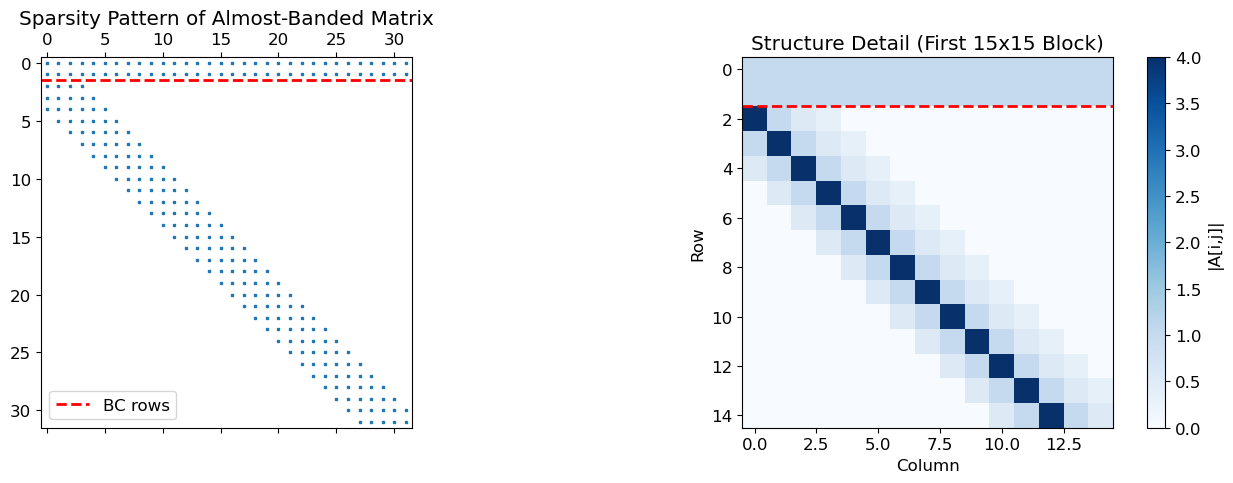

Matrix is 32x32
K = 2 dense BC rows (shown above red line)
Banded part has bandwidth m = mL + mR + 1 = 2 + 3 + 1 = 6


In [2]:
def create_almost_banded_matrix(n, K=2, mL=2, mR=3):
    """
    Create an almost-banded matrix like those from ultraspherical discretization.
    
    Parameters
    ----------
    n : int
        Matrix size.
    K : int
        Number of dense BC rows.
    mL : int
        Number of subdiagonals.
    mR : int
        Number of superdiagonals.
    """
    A = np.zeros((n, n))
    
    # BC rows: dense (like evaluation at boundary points)
    # T_k(-1) = (-1)^k, T_k(1) = 1
    A[0, :] = (-1.0) ** np.arange(n)
    A[1, :] = np.ones(n)
    
    # Banded interior (like differentiation operator)
    for i in range(K, n):
        # Diagonal
        A[i, i-K] = 4.0
        # Subdiagonals
        for j in range(1, mL+1):
            if i-K-j >= 0:
                A[i, i-K-j] = -1.0 / j
        # Superdiagonals  
        for j in range(1, mR+1):
            if i-K+j < n:
                A[i, i-K+j] = -1.0 / j
    
    return A

# Create and visualize
n = 32
A = create_almost_banded_matrix(n, K=2, mL=2, mR=3)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sparsity pattern
ax = axes[0]
ax.spy(A, markersize=2)
ax.axhline(1.5, color='r', linestyle='--', linewidth=2, label='BC rows')
ax.set_title('Sparsity Pattern of Almost-Banded Matrix')
ax.legend()

# Zoom on structure
ax = axes[1]
im = ax.imshow(np.abs(A[:15, :15]), cmap='Blues')
ax.axhline(1.5, color='r', linestyle='--', linewidth=2)
ax.set_title('Structure Detail (First 15x15 Block)')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im, ax=ax, label='|A[i,j]|')

plt.tight_layout()
plt.show()

print(f"Matrix is {n}x{n}")
print(f"K = 2 dense BC rows (shown above red line)")
print(f"Banded part has bandwidth m = mL + mR + 1 = 2 + 3 + 1 = 6")

## 3. Givens Rotations: The Building Block

A Givens rotation zeros out a single element by rotating two rows:

$$G = \begin{pmatrix} c & s \\ -s & c \end{pmatrix}, \quad c = \frac{a}{r}, \quad s = \frac{b}{r}, \quad r = \sqrt{a^2 + b^2}$$

Applied to $[a, b]^T$, it produces $[r, 0]^T$.

In [3]:
def givens_rotation(a, b):
    """
    Compute Givens rotation coefficients to zero out b.
    
    Returns (c, s) such that:
        [c  s] [a]   [r]
        [-s c] [b] = [0]
    where r = sqrt(a^2 + b^2).
    """
    if b == 0:
        return 1.0, 0.0
    elif a == 0:
        return 0.0, np.sign(b) * 1.0
    else:
        r = np.hypot(a, b)
        c = a / r
        s = b / r
        return c, s

def apply_givens(c, s, x, y):
    """
    Apply Givens rotation G = [[c, s], [-s, c]] to [x, y].
    """
    x_new = c * x + s * y
    y_new = -s * x + c * y
    return x_new, y_new

# Demonstrate
a, b = 3.0, 4.0
c, s = givens_rotation(a, b)
a_new, b_new = apply_givens(c, s, a, b)

print(f"Original: [a, b] = [{a}, {b}]")
print(f"Givens coefficients: c = {c:.4f}, s = {s:.4f}")
print(f"After rotation: [a', b'] = [{a_new:.4f}, {b_new:.4f}]")
print(f"r = sqrt(a^2 + b^2) = {np.sqrt(a**2 + b**2):.4f}")

Original: [a, b] = [3.0, 4.0]
Givens coefficients: c = 0.6000, s = 0.8000
After rotation: [a', b'] = [5.0000, -0.0000]
r = sqrt(a^2 + b^2) = 5.0000


## 4. QR Factorization via Givens Rotations

Standard QR produces $A = QR$ where $R$ is upper triangular.

With Givens rotations, we can compute $R$ **column by column**:
1. Process column $j$
2. Use Givens rotations to zero entries below the diagonal
3. Apply same rotations to the RHS

For almost-banded matrices:
- Column $j$ only has nonzeros in rows $0$ to $j + K + m_L$
- We only need $O(m)$ rotations per column
- Total cost: $O(nm^2)$ instead of $O(n^3)$!

In [4]:
def givens_qr_step(R, rhs, j, K, mL):
    """
    Process column j of QR factorization using Givens rotations.
    
    Eliminates entries in rows j+1 to j+K+mL of column j.
    
    Parameters
    ----------
    R : ndarray
        Working matrix (modified in place).
    rhs : ndarray
        Right-hand side (modified in place).
    j : int
        Column to process.
    K : int
        Number of BC rows.
    mL : int
        Number of subdiagonals.
    """
    m, n = R.shape
    
    # Last row with nonzero in column j (due to banded structure)
    last_row = min(j + K + mL, m - 1)
    
    # Eliminate from bottom to top
    for i in range(last_row, j, -1):
        if abs(R[i, j]) < 1e-15:
            continue
            
        # Givens rotation to zero R[i, j] using R[j, j]
        c, s = givens_rotation(R[j, j], R[i, j])
        
        # Apply to affected columns (j to end, but structure limits this)
        for col in range(j, n):
            R[j, col], R[i, col] = apply_givens(c, s, R[j, col], R[i, col])
        
        # Apply to RHS
        rhs[j], rhs[i] = apply_givens(c, s, rhs[j], rhs[i])

# Test on a small example
n_small = 8
A_small = create_almost_banded_matrix(n_small, K=2, mL=2, mR=3)
b_small = np.random.randn(n_small)

# Copy for Givens QR
R = A_small.copy()
rhs = b_small.copy()

# Process all columns
for j in range(n_small):
    givens_qr_step(R, rhs, j, K=2, mL=2)

# Compare with scipy QR
Q, R_scipy = qr(A_small)
rhs_scipy = Q.T @ b_small

# Back-substitute
from scipy.linalg import solve_triangular
x_givens = solve_triangular(R, rhs)
x_scipy = solve_triangular(R_scipy, rhs_scipy)
x_direct = solve(A_small, b_small)

print(f"Givens QR solution error: {np.linalg.norm(x_givens - x_direct):.2e}")
print(f"Scipy QR solution error:  {np.linalg.norm(x_scipy - x_direct):.2e}")

Givens QR solution error: 2.26e-16
Scipy QR solution error:  1.08e-15


## 5. The Key Insight: Convergence Detection

After processing column $j$, the transformed RHS looks like:

$$Q^T b = \begin{pmatrix} r_0 \\ r_1 \\ \vdots \\ r_j \\ \hline r_{j+1} \\ \vdots \\ r_{j+m_L} \\ \vdots \end{pmatrix}$$

If we **truncate** the solution to $j+1$ coefficients, the residual is:
$$\|r_{j+1:j+m_L}\|$$

When this is small, we've found the optimal discretization!

In [5]:
def adaptive_qr_solve(A, b, K, mL, tol=1e-10):
    """
    Adaptive QR solver for almost-banded systems.
    
    Stops as soon as the residual tail is small enough.
    
    Parameters
    ----------
    A : ndarray
        Almost-banded matrix.
    b : ndarray
        Right-hand side.
    K : int
        Number of BC rows.
    mL : int
        Number of subdiagonals.
    tol : float
        Convergence tolerance.
        
    Returns
    -------
    x : ndarray
        Solution (truncated to optimal size).
    n_opt : int
        Optimal discretization size.
    residual_history : list
        Residual tail norm at each column.
    """
    m, n = A.shape
    R = A.copy()
    rhs = b.copy()
    
    residual_history = []
    
    for j in range(n):
        # Process column j
        givens_qr_step(R, rhs, j, K, mL)
        
        # Check convergence: residual tail
        if j >= K - 1:
            tail_start = j + 1
            tail_end = min(tail_start + mL, m)
            
            if tail_end > tail_start:
                residual_tail = np.linalg.norm(rhs[tail_start:tail_end])
                residual_history.append(residual_tail)
                
                if residual_tail < tol:
                    # Converged! Back-substitute
                    n_opt = j + 1
                    x = np.zeros(n_opt)
                    for k in range(n_opt - 1, -1, -1):
                        x[k] = rhs[k]
                        for col in range(k + 1, n_opt):
                            x[k] -= R[k, col] * x[col]
                        if abs(R[k, k]) > 1e-15:
                            x[k] /= R[k, k]
                    return x, n_opt, residual_history
    
    # Didn't converge - solve full system
    x = np.zeros(n)
    for k in range(n - 1, -1, -1):
        x[k] = rhs[k]
        for col in range(k + 1, n):
            x[k] -= R[k, col] * x[col]
        if abs(R[k, k]) > 1e-15:
            x[k] /= R[k, k]
    
    return x, n, residual_history

## 6. Example: A Simple BVP

Let's test on a real ultraspherical discretization:

$$u'' = f(x), \quad u(-1) = u(1) = 0$$

The solution converges exponentially in Chebyshev coefficients if $f$ is smooth.

Full discretization size: n = 128
Adaptive QR found optimal size: n_opt = 11
Savings: 91.4% fewer columns processed

Solution error vs direct: 2.46e-08
Residual of truncated solution: 9.98e-11


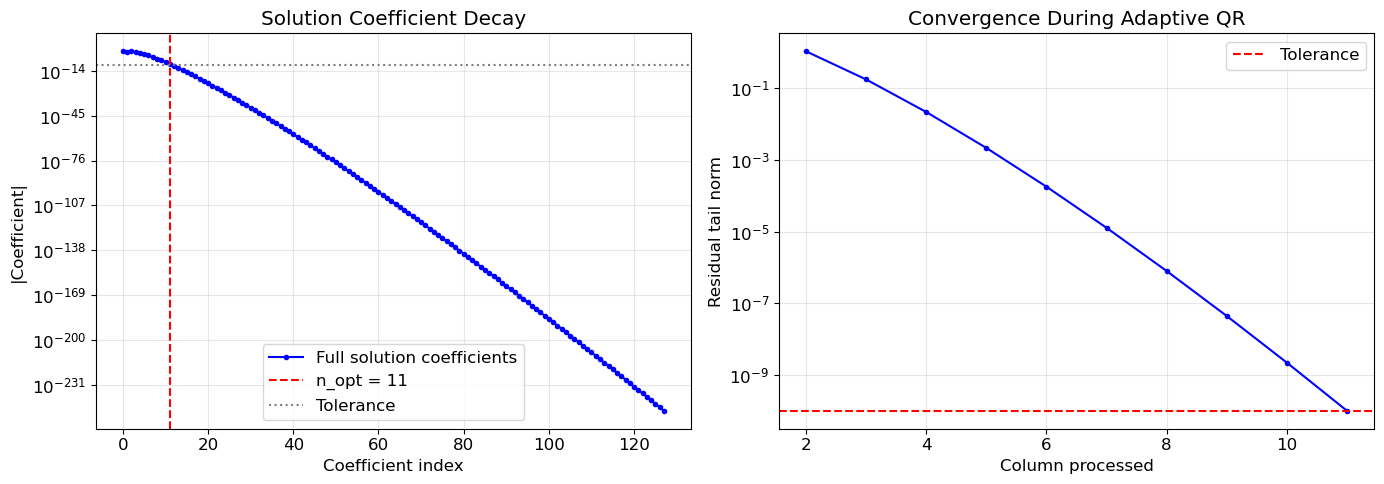

In [6]:
try:
    from funpy.colloc.ultraS.matrices import diffmat, convertmat
    from funpy.cheb import chebpts
    from scipy.special import iv as bessel_i
    
    # Build the discretization
    n = 128
    K = 2  # two Dirichlet BCs
    mL = 2  # D^2 creates 2 subdiagonals in ultraspherical
    
    # Differentiation and conversion matrices
    D2 = diffmat(n, m=2)  # 2nd derivative
    S2 = convertmat(n, 0, 2)  # C^0 -> C^2
    
    # Operator: u'' in ultraspherical basis
    L = S2 @ D2
    
    # BC rows: T_k(-1) = (-1)^k, T_k(1) = 1
    bc_left = (-1.0) ** np.arange(n)
    bc_right = np.ones(n)
    
    # Assemble full matrix
    A = np.zeros((n, n))
    A[0, :] = bc_left
    A[1, :] = bc_right
    A[K:, :] = L.toarray()[:n-K, :]
    
    # RHS: u'' = exp(x)
    # Chebyshev coefficients of exp(x) via Bessel functions
    f_coeffs = np.array([2 * bessel_i(k, 1) for k in range(n)])
    f_coeffs[0] /= 2
    
    b = np.zeros(n)
    b[0] = 0  # u(-1) = 0
    b[1] = 0  # u(1) = 0
    b[K:] = (S2 @ f_coeffs)[:n-K]  # Convert RHS to C^2 basis
    
    # Solve adaptively
    x, n_opt, res_history = adaptive_qr_solve(A, b, K, mL, tol=1e-10)
    
    # Compare with direct solve
    x_direct = solve(A, b)
    
    print(f"Full discretization size: n = {n}")
    print(f"Adaptive QR found optimal size: n_opt = {n_opt}")
    print(f"Savings: {100*(1 - n_opt/n):.1f}% fewer columns processed")
    
    # Verify solution
    x_full = np.zeros(n)
    x_full[:len(x)] = x
    print(f"\nSolution error vs direct: {np.linalg.norm(x - x_direct[:len(x)]):.2e}")
    print(f"Residual of truncated solution: {np.linalg.norm(A @ x_full - b):.2e}")
    
    # Plot coefficient decay
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax = axes[0]
    ax.semilogy(np.abs(x_direct), 'b.-', label='Full solution coefficients')
    ax.axvline(n_opt, color='r', linestyle='--', label=f'n_opt = {n_opt}')
    ax.axhline(1e-10, color='gray', linestyle=':', label='Tolerance')
    ax.set_xlabel('Coefficient index')
    ax.set_ylabel('|Coefficient|')
    ax.set_title('Solution Coefficient Decay')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1]
    ax.semilogy(np.arange(K, K + len(res_history)), res_history, 'b.-')
    ax.axhline(1e-10, color='r', linestyle='--', label='Tolerance')
    ax.set_xlabel('Column processed')
    ax.set_ylabel('Residual tail norm')
    ax.set_title('Convergence During Adaptive QR')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("funpy not available. Using simplified example...")
    
    # Simplified example with toy matrix
    n = 64
    A = create_almost_banded_matrix(n, K=2, mL=2, mR=3)
    
    # RHS that decays exponentially in solution
    b = np.zeros(n)
    b[2:] = np.exp(-np.arange(n-2) / 5)  # Decay
    
    x, n_opt, res_history = adaptive_qr_solve(A, b, K=2, mL=2, tol=1e-10)
    
    print(f"Full size: n = {n}")
    print(f"Optimal size found: n_opt = {n_opt}")
    print(f"Solution length: {len(x)}")

## 7. Using funpy's Built-in Adaptive QR

funpy has a complete implementation in `funpy.linalg.adaptive_qr`. Let's use it:

In [7]:
try:
    from funpy.linalg.adaptive_qr import AdaptiveQRSolver
    
    # Use funpy's solver
    solver = AdaptiveQRSolver(tol=1e-12)
    x_funpy, n_opt_funpy, info = solver.solve_from_matrix(A, b, K=K, mL=mL)
    
    print(f"funpy AdaptiveQRSolver results:")
    print(f"  Converged: {info['converged']}")
    print(f"  n_opt: {n_opt_funpy}")
    print(f"  Residual: {info['residual']:.2e}")
    print(f"  Columns processed: {info['columns_processed']}")
    
except ImportError:
    print("funpy.linalg.adaptive_qr not available")

funpy AdaptiveQRSolver results:
  Converged: True
  n_opt: 13
  Residual: 1.60e-13
  Columns processed: 13


## 8. Comparison: LU vs Adaptive QR

Let's compare the methods across different problem sizes:

     n  n_opt    LU (ms)   AQR (ms)       LU res      AQR res
------------------------------------------------------------
    32     13       0.20       0.09     1.57e-16     1.60e-13
    64     13       0.12       0.09     1.57e-16     1.60e-13
   128     13       0.21       0.13     1.57e-16     1.60e-13
   256     13       1.30       0.30     1.57e-16     1.60e-13


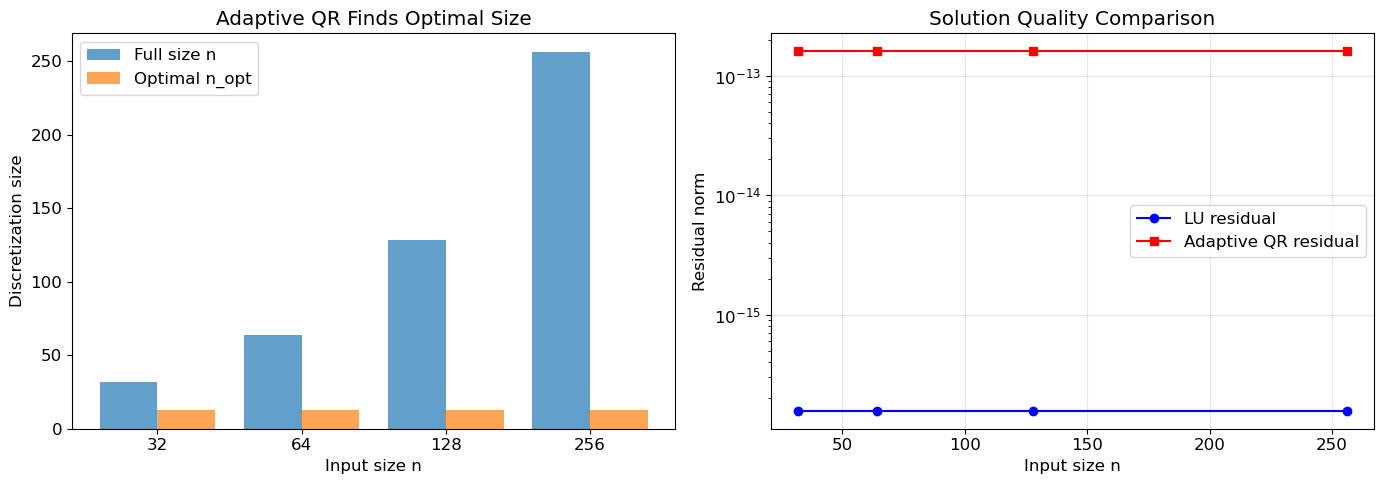

In [8]:
try:
    import time
    from funpy.colloc.ultraS.matrices import diffmat, convertmat
    from scipy.special import iv as bessel_i
    
    sizes = [32, 64, 128, 256]
    results = {'n': [], 'n_opt': [], 'lu_time': [], 'aqr_time': [], 'lu_res': [], 'aqr_res': []}
    
    for n in sizes:
        K, mL = 2, 2
        
        # Build system
        D2 = diffmat(n, m=2)
        S2 = convertmat(n, 0, 2)
        L = S2 @ D2
        
        A = np.zeros((n, n))
        A[0, :] = (-1.0) ** np.arange(n)
        A[1, :] = np.ones(n)
        A[K:, :] = L.toarray()[:n-K, :]
        
        f_coeffs = np.array([2 * bessel_i(k, 1) for k in range(n)])
        f_coeffs[0] /= 2
        
        b = np.zeros(n)
        b[K:] = (S2 @ f_coeffs)[:n-K]
        
        # LU solve
        t0 = time.perf_counter()
        x_lu = solve(A, b)
        lu_time = time.perf_counter() - t0
        
        # Adaptive QR solve
        t0 = time.perf_counter()
        x_aqr, n_opt, _ = adaptive_qr_solve(A, b, K, mL, tol=1e-12)
        aqr_time = time.perf_counter() - t0
        
        # Residuals
        x_aqr_full = np.zeros(n)
        x_aqr_full[:len(x_aqr)] = x_aqr
        
        results['n'].append(n)
        results['n_opt'].append(n_opt)
        results['lu_time'].append(lu_time * 1000)  # ms
        results['aqr_time'].append(aqr_time * 1000)
        results['lu_res'].append(np.linalg.norm(A @ x_lu - b))
        results['aqr_res'].append(np.linalg.norm(A @ x_aqr_full - b))
    
    # Display results
    print(f"{'n':>6} {'n_opt':>6} {'LU (ms)':>10} {'AQR (ms)':>10} {'LU res':>12} {'AQR res':>12}")
    print("-" * 60)
    for i in range(len(sizes)):
        print(f"{results['n'][i]:>6} {results['n_opt'][i]:>6} {results['lu_time'][i]:>10.2f} "
              f"{results['aqr_time'][i]:>10.2f} {results['lu_res'][i]:>12.2e} {results['aqr_res'][i]:>12.2e}")
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax = axes[0]
    ax.bar(np.arange(len(sizes)) - 0.2, results['n'], 0.4, label='Full size n', alpha=0.7)
    ax.bar(np.arange(len(sizes)) + 0.2, results['n_opt'], 0.4, label='Optimal n_opt', alpha=0.7)
    ax.set_xticks(np.arange(len(sizes)))
    ax.set_xticklabels([str(s) for s in sizes])
    ax.set_xlabel('Input size n')
    ax.set_ylabel('Discretization size')
    ax.set_title('Adaptive QR Finds Optimal Size')
    ax.legend()
    
    ax = axes[1]
    ax.semilogy(sizes, results['lu_res'], 'bo-', label='LU residual')
    ax.semilogy(sizes, results['aqr_res'], 'rs-', label='Adaptive QR residual')
    ax.set_xlabel('Input size n')
    ax.set_ylabel('Residual norm')
    ax.set_title('Solution Quality Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("funpy not available for full comparison")

## 9. Integration with Newton's Method

Adaptive QR can be used in two ways with nonlinear solvers:

1. **As a direct solver** for exact Newton methods (like `nleq_err`)
2. **As a preconditioner** for iterative Newton methods (like `ingu`)

The $R$ factor from adaptive QR gives us $R^{-1}$ as an efficient preconditioner!

Solving nonlinear BVP with adaptive QR linear solver...
Trying to sympify something!
diff(u, x, 2) + u**2 - 1
Trying to sympify something!
u(-1)
Trying to sympify something!
u(1)
Solving with standard LU linear solver...

Results:
Adaptive QR: success = True, coefficients = 30
Standard LU: success = True, coefficients = 32
Solution difference (L2 norm): 2.34e-14


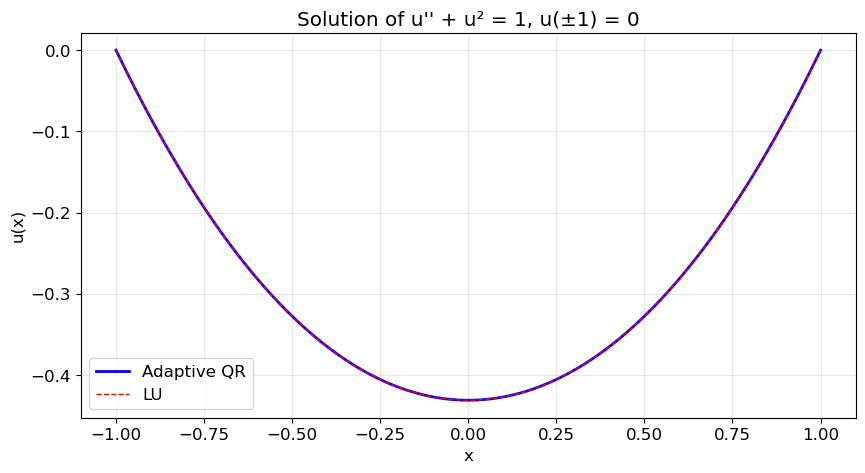

In [9]:
try:
    from funpy import Fun
    from funpy.colloc import ChebOp
    
    # Define a nonlinear BVP: u'' + u^2 = 1, u(-1) = u(1) = 0
    op = ChebOp(
        functions=['u'],
        colloc='ultraS',
        n=30,
        diff_order=2,
        domain=[-1, 1]
    )
    op.eqn = ['diff(u, x, 2) + u**2 - 1']
    op.bcs = ['u(-1)', 'u(1)']
    
    # Initial guess: zero function
    u0 = Fun(lambda x: np.zeros_like(x), [-1, 1])
    
    # Solve with adaptive QR as linear solver
    print("Solving nonlinear BVP with adaptive QR linear solver...")
    soln_aqr, success_aqr, res_aqr = op.solve(
        u0, adaptive=False, verbose=False,
        method='nleq-err', linear_solver='adaptive_qr'
    )
    
    # Compare with standard LU
    print("Solving with standard LU linear solver...")
    soln_lu, success_lu, res_lu = op.solve(
        u0, adaptive=False, verbose=False,
        method='nleq-err', linear_solver='lu'
    )
    
    # Compare solutions using Fun arithmetic
    diff = soln_aqr - soln_lu
    
    print(f"\nResults:")
    print(f"Adaptive QR: success = {success_aqr}, coefficients = {soln_aqr.shape[0]}")
    print(f"Standard LU: success = {success_lu}, coefficients = {soln_lu.shape[0]}")
    print(f"Solution difference (L2 norm): {diff.norm():.2e}")
    
    # Plot solution
    xx = np.linspace(-1, 1, 200)
    plt.figure(figsize=(10, 5))
    plt.plot(xx, soln_aqr(xx), 'b-', linewidth=2, label='Adaptive QR')
    plt.plot(xx, soln_lu(xx), 'r--', linewidth=1, label='LU')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title("Solution of u'' + u² = 1, u(±1) = 0")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
except ImportError as e:
    print(f"funpy not available: {e}")

## 10. Systems of Equations (N > 1)

Adaptive QR also works for **coupled systems** of ODEs. The key difference is the matrix ordering:

- **Block ordering** (how ultraS builds the matrix): $[u_0, u_1, ..., u_{n-1}, v_0, v_1, ..., v_{n-1}]$
- **Interleaved ordering** (what adaptive QR needs): $[u_0, v_0, u_1, v_1, ..., u_{n-1}, v_{n-1}]$

The interleaved ordering lets us check convergence after processing all variables at each degree level.

funpy handles this with an `InterleavedBlockView` class that provides virtual index translation - no physical permutation needed!

In [ ]:
try:
    from funpy import Fun
    from funpy.colloc import ChebOp
    
    # Cauchy-Riemann system: u - v' = 0, u' + v = 0
    # Exact solution: u = cos(x), v = sin(x)
    op = ChebOp(functions=['u', 'v'], domain=[-np.pi, np.pi])
    op.eqn = ['u - diff(v, x)', 'diff(u, x) + v']
    op.bcs = ['u(-pi) + 1', 'v(pi)']  # cos(-pi) = -1, sin(pi) = 0
    
    # Solve using adaptive QR (N=2 system)
    print("Solving 2x2 Cauchy-Riemann system with adaptive QR...")
    soln, success, res = op.solve(use_adaptive_qr=True, verbose=False)
    
    print(f"Success: {success}")
    print(f"Residual: {res:.2e}")
    
    # Compare with exact solution
    xx = np.linspace(-np.pi, np.pi, 200)
    u_exact = np.cos(xx)
    v_exact = np.sin(xx)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax = axes[0]
    ax.plot(xx, soln[0](xx), 'b-', linewidth=2, label='u (adaptive QR)')
    ax.plot(xx, u_exact, 'r--', linewidth=1, label='cos(x) (exact)')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
    ax.set_title('Solution u(x) = cos(x)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1]
    ax.plot(xx, soln[1](xx), 'b-', linewidth=2, label='v (adaptive QR)')
    ax.plot(xx, v_exact, 'r--', linewidth=1, label='sin(x) (exact)')
    ax.set_xlabel('x')
    ax.set_ylabel('v(x)')
    ax.set_title('Solution v(x) = sin(x)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Check errors
    u_err = np.max(np.abs(soln[0](xx) - u_exact))
    v_err = np.max(np.abs(soln[1](xx) - v_exact))
    print(f"\nMax error in u: {u_err:.2e}")
    print(f"Max error in v: {v_err:.2e}")
    
except ImportError as e:
    print(f"funpy not available: {e}")

## Summary

**Adaptive QR for spectral methods:**

1. **Almost-banded structure**: Ultraspherical methods give matrices with K dense BC rows + banded interior

2. **Column-by-column QR**: Givens rotations process one column at a time with O(m) work per column

3. **Convergence detection**: Monitor $\|r_{j+1:j+m_L}\|$ after each column - when small, stop!

4. **Automatic optimal size**: Finds $n_{\text{opt}}$ without knowing it in advance

5. **Systems support**: For N coupled equations, use interleaved ordering to check convergence at each degree level

6. **Well-conditioned**: QR factorization is numerically stable

**Applications:**
- Direct solver for linear BVPs (scalar and systems)
- Linear solver in Newton iterations
- Preconditioner for iterative methods (GMRES)

**Reference:** Olver & Townsend, "A Fast and Well-Conditioned Spectral Method", SIAM Review 2013